# Assigning Country Covariate Values To Measurements

## The IHME Country Covariates (from the shared.covariate table)

### Columns in the covariate table and the Number of active and inactive covariates

In [1]:
# columns in the shared.covariate table, and number of active and inactive covariates
from db_tools.ezfuncs import query
df = query("select * from shared.covariate", conn_def="dismod-at-dev")
print(f"Columns in the shared.covariate table:")
print()
print(list(df.columns))
print()
print(df.shape)
print()
print(f"Number of active and inactive covariates: {df.shape[0]}") 

Columns in the shared.covariate table:

['covariate_id', 'covariate_name_short', 'covariate_name', 'covariate_lancet_label', 'requested_by', 'covariate_description', 'group_display', 'by_age', 'by_sex', 'dichotomous', 'inactive', 'covariate_type_id', 'start_date', 'end_date', 'date_inserted', 'last_updated', 'last_updated_by', 'last_updated_action']

(1191, 18)

Number of active and inactive covariates: 1191


### Descriptives of the Active Covariates (which populate the EpiViz drop-down list)

In [2]:
df_active = df[df["inactive"] == 0]
print(f"Number of active covariates: {len(df_active)}")
print()
print("Types of Active Covariates")
print()
not_by_age_not_by_sex = len(df_active[(df_active["by_age"] == 0) & (df_active["by_sex"] == 0)])
print(f"not_by_age_not_by_sex: {not_by_age_not_by_sex}")
not_by_age_but_by_sex = len(df_active[(df_active["by_age"] == 0) & (df_active["by_sex"] == 1)])
print(f"not_by_age but by_sex: {not_by_age_but_by_sex}")
not_by_sex_but_by_age = len(df_active[(df_active["by_age"] == 1) & (df_active["by_sex"] == 0)])
print(f"not_by_sex but by_age: {not_by_sex_but_by_age}")
by_age_and_by_sex = len(df_active[(df_active["by_age"] == 1) & (df_active["by_sex"] == 1)])
print(f"by_age and by_sex: {by_age_and_by_sex}")
print()
df_dichot = df_active[df_active["dichotomous"]==1]
print(f"Number of active dichotomous covariates: {len(df_dichot)}")
print()
covs_dichot = ('\n').join(df_dichot['covariate_name_short'].tolist())
print(f"Active dichotomous covariates \n\n {covs_dichot}")

Number of active covariates: 661

Types of Active Covariates

not_by_age_not_by_sex: 277
not_by_age but by_sex: 202
not_by_sex but by_age: 8
by_age and by_sex: 174

Number of active dichotomous covariates: 6

Active dichotomous covariates 

 H5N1_epidemic_yrs_bin
cv_je_bin
fortification_standard
fortification_standard_FA
fortification_standard_iron
censuses


## Possible Algorithms for assigning country covariate values to measurements

### Algorithm 1: kdtree based on 3 dimensions - age, time, and sex

### Algorithm 2: interpolation grid by sex, with age and time dimensions

Linear interpolation is used to determine a covariate value over an age and time grid 
specified by the mid-points of the age and time intervals in the covariate data.  


### Algorithm 3:  population-weighted interpolation grid by sex, with age and time dimensions

## Get the Covariate and Measurement Data to Try Out Algorithm 2

In [4]:
# imports
from cascade.input_data.db.bundle import _get_bundle_data
from cascade.testing_utilities import make_execution_context
from cascade.input_data.configuration.builder import (
    get_all_age_spans, 
    convert_gbd_ids_to_dismod_values,
    assign_interpolated_covariate_values,
    compute_covariate_age_time_dimensions, 
    select_interpolator_based_on_at_dims, 
    generate_covariate_interpolators_by_sex,
    compute_covariate_age_interval, 
    compute_interpolated_covariate_values_by_sex)
from cascade.input_data.db.ccov import country_covariates

In [5]:
# create execution context
execution_context = make_execution_context()
execution_context.parameters.gbd_round_id = 5

### Measurement Data - Diabetes, bundle = 173

In [6]:
# measurements - diabetes
bundle_id = 173
tier = 3
print(f"measurement bundle {bundle_id}, tier {tier}")
print()
measurements = _get_bundle_data(execution_context, bundle_id)

measurements["x_sex"] = measurements["sex_id"].replace([1,2,3],[0.5,-0.5,0])

measurements["age_lower"] = measurements["age_start"]
measurements["age_upper"] = measurements["age_end"]

measurements["time_lower"] = measurements["year_start"]
measurements["time_upper"] = measurements["year_end"]

measurements["avg_age"] = measurements[["age_lower", "age_upper"]].mean(axis=1)
measurements["avg_time"] = measurements[["time_lower", "time_upper"]].mean(axis=1)

print(f"measurements columns \n{measurements.columns}")
print()
print(measurements.shape)
print()

# measure_id's: 5=prevalence, 6=incidence, 11=relrisk, 13=mtwith
print("measure ids")
print(measurements["measure_id"].unique())
print()

tm = measurements["avg_time"].unique()
tml = tm.tolist()
tml.sort()
print("measurements time mid-point")
print(tml)      
print()

am = measurements["avg_age"].unique()
aml = am.tolist()
aml.sort()
print("measurements age mid-point")
print(aml)
print()


measurement bundle 173, tier 3

measurements columns 
Index(['bundle_id', 'seq', 'request_id', 'input_type_id', 'nid',
       'underlying_nid', 'location_id', 'sex_id', 'year_start', 'year_end',
       'age_start', 'age_end', 'measure_id', 'source_type_id',
       'sampling_type_id', 'representative_id', 'urbanicity_type_id',
       'recall_type_id', 'recall_type_value', 'unit_type_id',
       'unit_value_as_published', 'uncertainty_type_id',
       'uncertainty_type_value', 'mean', 'lower', 'upper', 'standard_error',
       'effective_sample_size', 'sample_size', 'cases', 'design_effect',
       'outlier_type_id', 'x_sex', 'age_lower', 'age_upper', 'time_lower',
       'time_upper', 'avg_age', 'avg_time'],
      dtype='object')

(470382, 39)

measure ids
[ 5 11 13  6]

measurements time mid-point
[1965.0, 1968.5, 1970.0, 1971.5, 1975.0, 1978.0, 1979.0, 1980.0, 1981.0, 1981.5, 1982.0, 1982.5, 1983.0, 1983.5, 1984.0, 1984.5, 1985.0, 1985.5, 1986.0, 1986.5, 1987.0, 1987.5, 1988.0, 1988.5

### Country Covariate = Cumulative Cigarettes 20 yrs, location = USA

1748 rows of data = 23 age groups * 38 years * 2 sexes

In [7]:
# covariates - cum cigs 20 yr, location = USA

covariate_id = 26
location_id = 102
demographics = dict(
            age_group_ids="all", year_ids="all", sex_ids="all", location_ids=[location_id]
        )
covariates = country_covariates(covariate_id, demographics, execution_context.parameters.gbd_round_id)

covariate_name = covariates.iloc[0]["covariate_name_short"]
print(f"covariate {covariate_name}, covariate_id = {covariate_id}")
print()

print(f"covariates columns {list(covariates.columns)}")
print()      
print(f"covariates shape: {covariates.shape}")
print()
print(f"covariates location_ids: {covariates['location_id'].unique()}")
print()
print(f"covariates age_group_ids: {covariates['age_group_id'].unique()}")
print()

age_groups = get_all_age_spans(execution_context)
print("age groups")
print(list(age_groups.columns))
print(age_groups.shape)
print()
      
# -----------------------------
# add age start and end cols      
# -----------------------------
ccov_ranges_df = convert_gbd_ids_to_dismod_values(covariates, age_groups)

print(f"ccov_ranges_df columns \n {list(ccov_ranges_df.columns)}")
print()
print(f"ccov_ranges_df shape: {ccov_ranges_df.shape}")
print()

print("unique x_sex values")
print(ccov_ranges_df["x_sex"].unique())
print()

ccov_ranges_df["avg_time"] = ccov_ranges_df[["time_lower", "time_upper"]].mean(axis=1)
print("Covariates time mid-point")
print(ccov_ranges_df["avg_time"].unique())
print()
print("Covariates time_lower")
print(ccov_ranges_df["time_lower"].unique())
print()
print("Covariates time_upper")
print(ccov_ranges_df["time_upper"].unique())
print()

ccov_ranges_df["avg_age"] = ccov_ranges_df[["age_lower", "age_upper"]].mean(axis=1)      
      
ac = ccov_ranges_df["avg_age"].unique()
acl = ac.tolist()
acl.sort()
print(f"Covariates age mid-point \n {acl}")
print()
      
# -----------------------------------------------------------------
# Isolate on a couple of years of covariate data - 2002 and 2003     
# -----------------------------------------------------------------
      
ccov_ranges_df_2003 = ccov_ranges_df[ccov_ranges_df["avg_time"] == 2003.5]
print(f"ccov_ranges_df_2003.5 shape: {ccov_ranges_df_2003.shape}")
ccov_ranges_df_2002 = ccov_ranges_df[ccov_ranges_df["avg_time"] == 2002.5]
print(f"ccov_ranges_df_2002.5 shape: {ccov_ranges_df_2002.shape}")

covariate cum_cigs_20_yr, covariate_id = 26

covariates columns ['covariate_id', 'covariate_name_short', 'location_id', 'age_group_id', 'year_id', 'sex_id', 'mean_value']

covariates shape: (1748, 7)

covariates location_ids: [102]

covariates age_group_ids: [  2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19
  20  30  31  32 235]

age groups
['age_group_id', 'age_group_years_start', 'age_group_years_end']
(406, 3)

ccov_ranges_df columns 
 ['index', 'covariate_id', 'covariate_name_short', 'location_id', 'sex_id', 'mean_value', 'age_lower', 'age_upper', 'x_sex', 'time_lower', 'time_upper']

ccov_ranges_df shape: (1748, 11)

unique x_sex values
[ 0.5 -0.5]

Covariates time mid-point
[1980.5 1981.5 1982.5 1983.5 1984.5 1985.5 1986.5 1987.5 1988.5 1989.5
 1990.5 1991.5 1992.5 1993.5 1994.5 1995.5 1996.5 1997.5 1998.5 1999.5
 2000.5 2001.5 2002.5 2003.5 2004.5 2005.5 2006.5 2007.5 2008.5 2009.5
 2010.5 2011.5 2012.5 2013.5 2014.5 2015.5 2016.5 2017.5]

Covariates time_

### Assign a Country Covariate Value to each Measurement Value

Note: this call creates three 2d interpolators - one for females, one for males, and one for both.
A RuntimeWarning is occurring when each is created.

In [8]:
# Compute Assigned Covariate Value

covariate_column = assign_interpolated_covariate_values(measurements, ccov_ranges_df)
# add the assigned covariate values to the measurement data
measurements["covariate_col"] = covariate_column

print(f"covariate_column shape \n {covariate_column.shape}")
print()

/home/nhawkins/env/cascade/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:976: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=27,37 m=874 fp=12.855921 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
/home/nhawkins/env/cascade/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:976: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=27,37 m=874 fp=11.677873 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
/home/nhawkins/env/cascade/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:976: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data point

covariate_column shape 
 (470382,)



Subset Measurements on Sex=Both and Measure Prevalence

In [8]:
# subset on sex "both" and prevalence

meas_5_both = measurements[(measurements["x_sex"] == 0) & (measurements["measure_id"] == 5)]

print("measurements subset: sex 'both' and prevalence")
print(meas_5_both.shape)
print()

print("avg_time")
tm5 = meas_5_both["avg_time"].unique()
tm5l = tm5.tolist()
tm5l.sort()
print(tm5l)
print()

print("avg_age")
am5 = meas_5_both["avg_age"].unique()
am5l = am5.tolist()
am5l.sort()
print(am5l)
print()

measurements subset: sex 'both' and prevalence
(5117, 40)

avg_time
[1980.0, 1983.0, 1985.0, 1987.0, 1989.0, 1991.5, 1992.0, 1992.5, 1993.5, 1995.0, 1995.5, 1996.0, 1996.5, 1997.0, 1998.0, 1998.5, 1999.0, 1999.5, 2000.0, 2000.5, 2001.0, 2001.5, 2002.0, 2002.5, 2003.0, 2003.5, 2004.0, 2004.5, 2005.0, 2005.5, 2006.0, 2006.5, 2007.0, 2007.5, 2008.0, 2008.5, 2009.0, 2009.5, 2010.0, 2010.5, 2011.0, 2011.5, 2012.0, 2012.5, 2013.0, 2013.5, 2014.0, 2015.0]

avg_age
[3.0, 5.5, 7.0, 9.5, 11.0, 12.5, 14.5, 15.0, 17.0, 17.5, 18.5, 19.5, 21.0, 21.5, 22.0, 23.5, 24.5, 25.5, 26.0, 26.5, 27.0, 28.0, 28.5, 29.5, 30.0, 31.0, 32.0, 32.5, 34.5, 35.0, 35.5, 37.0, 39.5, 40.5, 41.5, 42.0, 43.5, 44.5, 45.5, 46.0, 46.5, 47.0, 47.5, 48.5, 49.0, 49.5, 50.0, 50.5, 51.5, 52.0, 52.5, 53.0, 54.5, 55.0, 55.5, 56.0, 57.0, 57.5, 58.5, 59.0, 59.5, 60.0, 60.5, 61.0, 61.5, 62.0, 62.5, 63.0, 64.5, 65.5, 67.0, 69.5, 70.0, 70.5, 72.0, 74.5, 75.0, 76.5, 77.0, 79.5, 80.0, 82.0, 84.0, 84.5, 85.5, 87.0, 89.5, 95.0, 98.5]



Subset Measurements on Sex=Female and Measure Prevalence

In [11]:
meas_5_f = measurements[(measurements["x_sex"] == -0.5) & (measurements["measure_id"] == 5)]
print(f"meas_5_f shape: {meas_5_f.shape}")

meas_5_f shape: (214657, 40)


Subset Measurements on Sex=Male and Measure Prevalence

In [12]:
meas_5_m = measurements[(measurements["x_sex"] == 0.5) & (measurements["measure_id"] == 5)]
print(f"meas_5_m shape: {meas_5_m.shape}")

meas_5_m shape: (217321, 40)


Subset Measurements on Measure Prevalence

In [13]:
meas_5 = measurements[measurements["measure_id"] == 5]
print(f"meas_5 shape: {meas_5.shape}")

meas_5 shape: (437095, 40)


Subset Measurements on Measure Not Prevalance

In [18]:
meas_not_5 = measurements[measurements["measure_id"] != 5]
print(f"meas_not_5 shape: {meas_not_5.shape}")
print(f"the other measures are: {meas_not_5['measure_id'].unique()}")

meas_not_5 shape: (33287, 40)
the other measures are: [11 13  6]


## Tests

In [9]:
# covariates has 23 age groups, 38 years, and 2 sexes (f, m)
print(covariates.shape)
print(ccov_ranges_df.shape)

assert ccov_ranges_df.shape[0] == 23*38*2

(1748, 7)
(1748, 13)


In [10]:
# covariates has 23 age groups and 38 years, so expect age and time dimension
covar_at_dims = compute_covariate_age_time_dimensions(ccov_ranges_df)

print(len(covar_at_dims))
print(covar_at_dims["age_1d"])
print(covar_at_dims["time_1d"])

assert covar_at_dims["age_1d"]
assert covar_at_dims["time_1d"]

2
True
True


In [11]:
# covariates has age and time dimensions, so expect a 2d interpolator
interp = select_interpolator_based_on_at_dims(ccov_ranges_df, covar_at_dims)
print(type(interp))

<class 'scipy.interpolate.interpolate.interp2d'>


/home/nhawkins/env/cascade/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:976: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=32,61 m=1748 fp=69910017.371328 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))


In [12]:
ccov_ranges_df

# get a dictionary of interpolators - one for each sex (female, male, and both)
interp_dict = generate_covariate_interpolators_by_sex(ccov_ranges_df, covar_at_dims)

print(len(interp_dict))
print(interp_dict.keys())
print(type(interp_dict[-0.5]))
print(type(interp_dict[0.5]))
print(type(interp_dict[0]))

assert len(interp_dict) == 3

3
dict_keys([-0.5, 0.5, 0])
<class 'scipy.interpolate.interpolate.interp2d'>
<class 'scipy.interpolate.interpolate.interp2d'>
<class 'scipy.interpolate.interpolate.interp2d'>


In [13]:
covar_age_interval = compute_covariate_age_interval(ccov_ranges_df)
print(covar_age_interval)

assert 0 in covar_age_interval
assert 50 in covar_age_interval
assert 125 in covar_age_interval
assert 126 not in covar_age_interval
assert -1 not in covar_age_interval

[0.0,125.0]


In [14]:
cov_col = compute_interpolated_covariate_values_by_sex(measurements, interp_dict, covar_at_dims, 
                                                       covar_age_interval)
print(f"measurements shape: {measurements.shape}")
print(type(cov_col))
print(f"cov_col shape: {cov_col.shape}")

assert len(measurements) == len(cov_col)

measurements shape: (470382, 40)
<class 'pandas.core.series.Series'>
cov_col shape: (470382,)


In [60]:
interp_both = interp_dict[0]
print(type(interp_both))

interp_male = interp_dict[0.5]
print(type(interp_male))

interp_female = interp_dict[-0.5]
print(type(interp_female))
print()

# examine covariate values

cov_m_42p5_1980 = ccov_ranges_df[(ccov_ranges_df["avg_time"] == 1980.5) & 
                       (ccov_ranges_df["avg_age"] == 42.5) &
                       (ccov_ranges_df["x_sex"] == 0.5)]["mean_value"]

cov_m_37p5_2002 = ccov_ranges_df[(ccov_ranges_df["avg_time"] == 2002.5) & 
                       (ccov_ranges_df["avg_age"] == 37.5) &
                       (ccov_ranges_df["x_sex"] == 0.5)]["mean_value"]

cov_m_42p5_2002 = ccov_ranges_df[(ccov_ranges_df["avg_time"] == 2002.5) & 
                       (ccov_ranges_df["avg_age"] == 42.5) &
                       (ccov_ranges_df["x_sex"] == 0.5)]["mean_value"]

cov_m_37p5_2003 = ccov_ranges_df[(ccov_ranges_df["avg_time"] == 2003.5) & 
                       (ccov_ranges_df["avg_age"] == 37.5) &
                       (ccov_ranges_df["x_sex"] == 0.5)]["mean_value"]

cov_m_42p5_2003 = ccov_ranges_df[(ccov_ranges_df["avg_time"] == 2003.5) & 
                       (ccov_ranges_df["avg_age"] == 42.5) &
                       (ccov_ranges_df["x_sex"] == 0.5)]["mean_value"]


print(f"covariate value for male, 1980, 42.5: {list(cov_m_42p5_1980)}")

print(f"covariate value for male, 2002, 37.5: {list(cov_m_37p5_2002)}")
print(f"covariate value for male, 2002, 42.5: {list(cov_m_42p5_2002)}")

print(f"covariate value for male, 2003, 37.5: {list(cov_m_37p5_2003)}")
print(f"covariate value for male, 2003, 42.5: {list(cov_m_42p5_2003)}")
print()

# interpolate ccov value for age, time

print(f"interpolated value: female, 40.5, 1980, {interp_female(40.5, 1980)}")

print(f"interpolated value: female, 40.5, 2003, {interp_female(40.5, 2003)}")

print(f"interpolated value: male, 40.5, 1980, {interp_male(40.5, 1980)}")

print(f"interpolated value: male, 40.5, 2003, {interp_male(40.5, 2003)}")
      
print(f"interpolated value: both, 40.5, 1980, {interp_both(40.5, 1980)}")

print(f"interpolated value: both, 40.5, 2003, {interp_both(40.5, 2003)}")

print()      

<class 'scipy.interpolate.interpolate.interp2d'>
<class 'scipy.interpolate.interpolate.interp2d'>
<class 'scipy.interpolate.interpolate.interp2d'>

covariate value for male, 1980, 42.5: [4919.19753090102]
covariate value for male, 2002, 37.5: [1518.9552468454199]
covariate value for male, 2002, 42.5: [1915.6339250152398]
covariate value for male, 2003, 37.5: [1396.29178677209]
covariate value for male, 2003, 42.5: [1759.2197172720898]

interpolated value: female, 40.5, 1980, [1062.89741004]
interpolated value: female, 40.5, 2003, [333.71645634]
interpolated value: male, 40.5, 1980, [1519.34607756]
interpolated value: male, 40.5, 2003, [390.96848831]
interpolated value: both, 40.5, 1980, [1304.19818429]
interpolated value: both, 40.5, 2003, [366.87772552]



In [71]:
from scipy.interpolate import griddata
covs_m = ccov_ranges_df[ccov_ranges_df["x_sex"] == 0.5]

griddata_m = griddata( (covs_m["avg_age"], covs_m["avg_time"]), covs_m["mean_value"], ([42,42,42,42], [1980.5,1985,2002,2003]) )

print(type(griddata_m))
print(griddata_m.shape)
print(griddata_m)

<class 'numpy.ndarray'>
(4,)
[4992.91345524 4852.41067621 1958.38155127 1797.75895333]


## 3D Plots

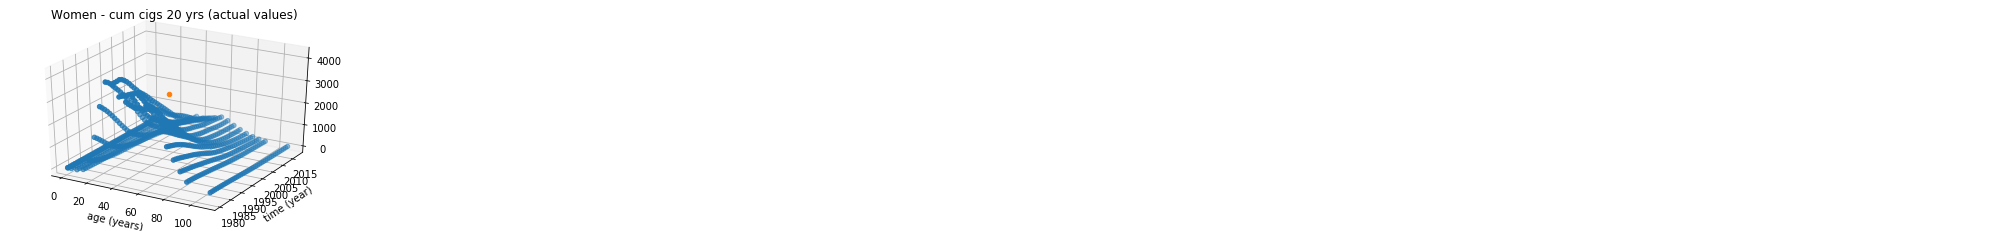

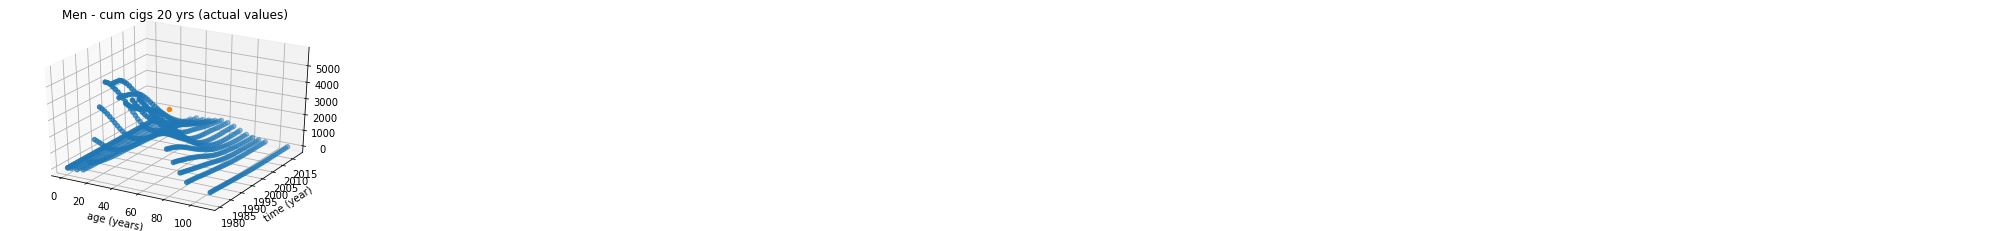

In [30]:
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

ccov_f = ccov_ranges_df[ccov_ranges_df["x_sex"] == -0.5]
ccov_m = ccov_ranges_df[ccov_ranges_df["x_sex"] == 0.5]

fig= plt.figure()
ax = plt.axes(projection='3d')

ax.scatter3D(ccov_f["avg_age"], ccov_f["avg_time"], ccov_f["mean_value"])

ax.scatter3D([40],[2003],[2500], "rr")

plt.xlabel("age (years)")
plt.ylabel("time (year)")
plt.title("Women - cum cigs 20 yrs (actual values)")

fig= plt.figure()
ax = plt.axes(projection='3d')

ax.scatter3D(ccov_m["avg_age"], ccov_m["avg_time"], ccov_m["mean_value"])

ax.scatter3D([40],[2003],[2500], "rr")

plt.xlabel("age (years)")
plt.ylabel("time (year)")
plt.title("Men - cum cigs 20 yrs (actual values)")

plt.show()

(8, 6)
[[  0  20  40  60  80 100]
 [  0  20  40  60  80 100]
 [  0  20  40  60  80 100]
 [  0  20  40  60  80 100]
 [  0  20  40  60  80 100]
 [  0  20  40  60  80 100]
 [  0  20  40  60  80 100]
 [  0  20  40  60  80 100]]
(8, 6)
[[1980 1980 1980 1980 1980 1980]
 [1985 1985 1985 1985 1985 1985]
 [1990 1990 1990 1990 1990 1990]
 [1995 1995 1995 1995 1995 1995]
 [2000 2000 2000 2000 2000 2000]
 [2005 2005 2005 2005 2005 2005]
 [2010 2010 2010 2010 2010 2010]
 [2015 2015 2015 2015 2015 2015]]
(8, 6)


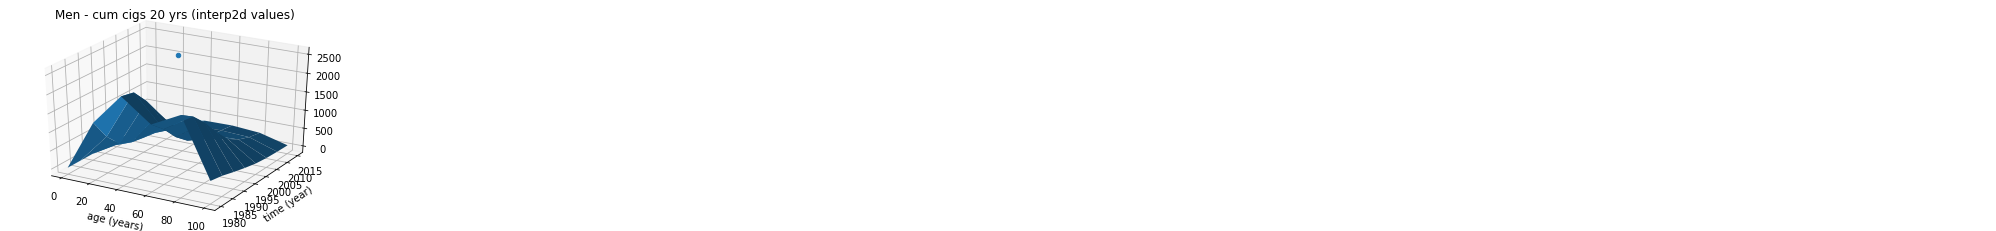

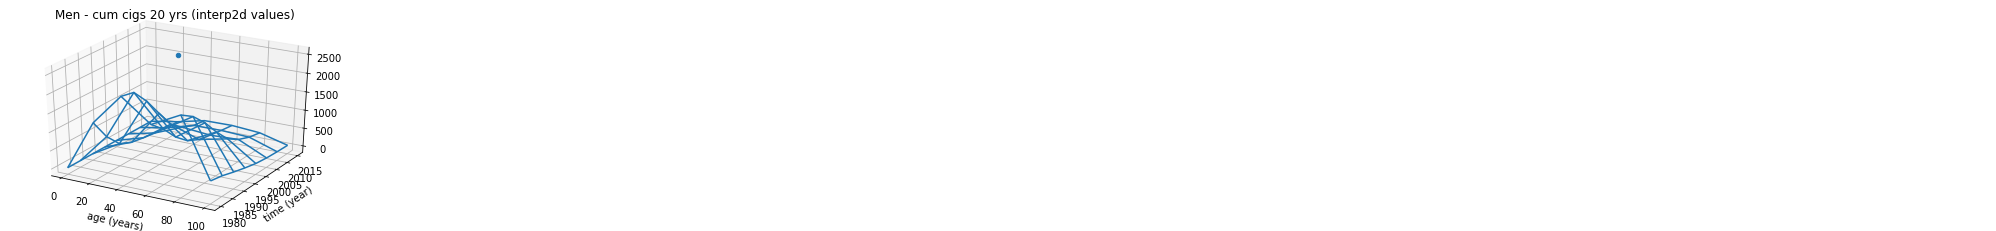

In [53]:
import numpy as np
from itertools import repeat

ages = [0, 20, 40, 60, 80, 100]
times = [1980, 1985, 1990, 1995, 2000, 2005, 2010, 2015]

x = ages * 8
y = list(np.array(list(repeat(times,len(ages)))).flatten())

x_2d = np.reshape(x, (len(times), len(ages)) )
print(x_2d.shape)
print(x_2d)

y_2d = np.reshape(np.repeat(times, len(ages)), (len(times), len(ages)))
print(y_2d.shape)
print(y_2d)

z_2d = interp_male(ages, times)
print(z_2d.shape)
z = z_ndarray.flatten()

fig= plt.figure()
ax = plt.axes(projection='3d')

ax.plot_surface(x_2d, y_2d, z_2d)

ax.scatter3D([40],[2003],[2500], "ro")

plt.xlabel("age (years)")
plt.ylabel("time (year)")
plt.title("Men - cum cigs 20 yrs (interp2d values)")


fig= plt.figure()
ax = plt.axes(projection='3d')

ax.plot_wireframe(x_2d, y_2d, z_2d)

ax.scatter3D([40],[2003],[2500], "ro")

plt.xlabel("age (years)")
plt.ylabel("time (year)")
plt.title("Men - cum cigs 20 yrs (interp2d values)")

plt.show()

### griddata plots

length z_2d: 8


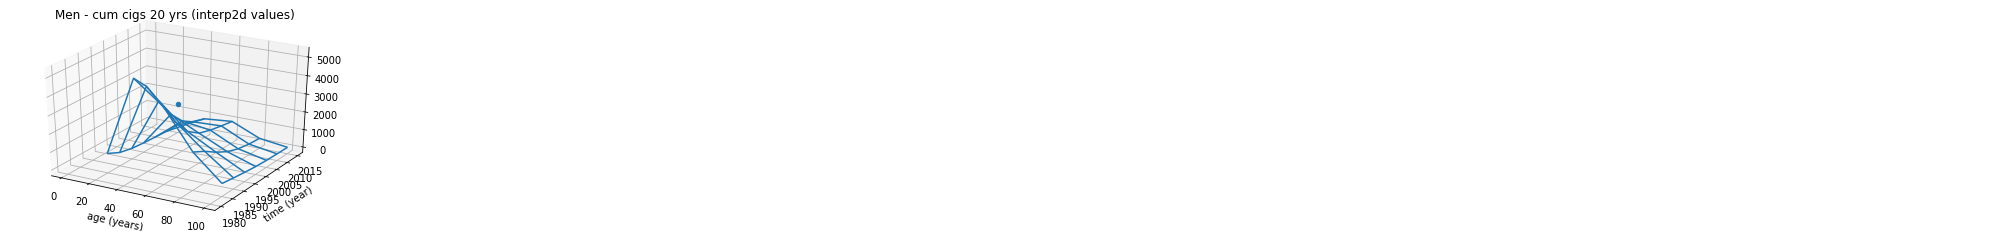

In [73]:
z_2d = griddata((covs_m["avg_age"], covs_m["avg_time"]), covs_m["mean_value"], (x_2d, y_2d)) 
print(f"length z_2d: {len(z_2d)}")

fig= plt.figure()
ax = plt.axes(projection='3d')

ax.plot_wireframe(x_2d, y_2d, z_2d)

ax.scatter3D([40],[2003],[2500], "ro")

plt.xlabel("age (years)")
plt.ylabel("time (year)")
plt.title("Men - cum cigs 20 yrs (interp2d values)")

plt.show()

## Examples:  matching covariate values with measurement data

Case 1: the covariate is not a by_age covariate (in which case there is only one "age" in the data, age_group = 22 or age_group = 27) and exists for more than one year.  A 1D linear interpolation is used over time.

In [81]:
print(f"not_by_age covariate")
print()
# this is not the case for covariate 26, it is by_age

# look at two covariates - cigs per capita (14) and mean_BMI (68)
covariate_id = 14
covs = country_covariates(covariate_id, demographics, execution_context.parameters.gbd_round_id)
print(f"covs_14 shape: {covs.shape}")

print(f"covariates location_ids: {covs['location_id'].unique()}")
print()
print(f"covariates age_group_ids: {covs['age_group_id'].unique()}")
print()
print(f"covariates sex_ids: {covs['sex_id'].unique()}")
print()
print(f"covariates year_ids: {covs['year_id'].unique()}")
print()
      
covariate_id = 68
covs = country_covariates(covariate_id, demographics, execution_context.parameters.gbd_round_id)
print(f"covs_68 shape: {covs.shape}")
print()
print(f"covariates location_ids: {covs['location_id'].unique()}")
print()
print(f"covariates age_group_ids: {covs['age_group_id'].unique()}")
print()
print(f"covariates sex_ids: {covs['sex_id'].unique()}")
print()
print(f"covariates year_ids: {covs['year_id'].unique()}")
print()
      

not_by_age covariate

covs_14 shape: (58, 7)
covariates location_ids: [102]

covariates age_group_ids: [22]

covariates sex_ids: [3]

covariates year_ids: [1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973
 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987
 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001
 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015
 2016 2017]

covs_68 shape: (76, 7)

covariates location_ids: [102]

covariates age_group_ids: [22]

covariates sex_ids: [1 2]

covariates year_ids: [1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993
 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007
 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017]



Case 2: the covariate exists for only one year and for more than one age.  A 1D linear interpolation is used over age.

In [151]:
# subset covariate 26 data for the example, by selecting out only year 2003
cov_col_2003 = assign_interpolated_covariate_values(measurements, ccov_ranges_df_2003)

print(f"covariate_column_2003 shape \n {cov_col_2003.shape}")
print()

covariate_column_2003 shape 
 (275800,)



Case 3: the covariate has multiple age_group values and multiple year values.  A 2D linear 
    interpolation is used.

In [ ]:
# use covariate_column computed above


Case 4: the covariate is not by_sex.  A single interpolator is used for female, male, and 
    both_sexes measurement values.

In [ ]:
# covariate 26 is by_sex

Case 5: the covariate is by_sex. Three separate interpolators are created - one for females, one for males, and the average of the male and female values for both_sexes (the covariate data will exist for males and females, but not for both)

In [152]:
# this is true for covariate 26

Case 6: measurement value has an age interval which does not overlap with the age intervals available in the covariate data, the covariate value is assigned missing.  For example, the covariate might apply only to adults, and not to children.  

In [160]:
# Q: is this true for covariate 26? 
# A: data exists where you might not expect it, but the value is zero

ccov_age_3 = ccov_ranges_df[ccov_ranges_df['avg_age'] == 3]
print(f"cumumlative cigs for 20 yrs, for avg age 3 \n {ccov_age_3.shape}")
print()
print(f"min cov value {ccov_age_3['mean_value'].min()}")
print(f"max cov value {ccov_age_3['mean_value'].max()}")
      

cumumlative cigs for 20 yrs, for avg age 3 
 (76, 13)

min cov 0.0
max cov 0.0


Case 7: the measurement value has a year which falls outside the covariate interpolation grid, an extrapolated value will be assigned. 

In [161]:
# the measurement data has a number of years before 1980 where the covariate data begins

plot experiments

(874, 13)
(874, 13)
meas_ss_405: (7, 40)
(7, 40)
1389      2003
40789     2003
80189     2003
119589    2003
158989    2003
198389    2003
237789    2003
Name: time_lower, dtype: int64
1389      2003
40789     2003
80189     2003
119589    2003
158989    2003
198389    2003
237789    2003
Name: time_upper, dtype: int64
cov_m_2003: (23, 13)
cov_m_2002: (23, 13)
cov_f_2003: (23, 13)
cov_f_2002: (23, 13)
meas_2003 shape: (91, 40)
meas_2003 40.5: 
1389      366.877726
40789     366.877726
80189     366.877726
119589    366.877726
158989    366.877726
198389    366.877726
237789    366.877726
Name: covariate_col, dtype: float64


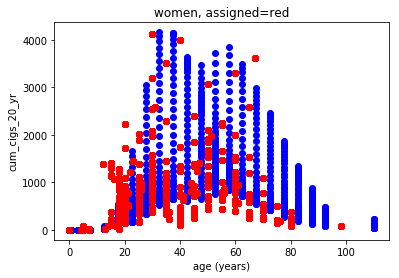

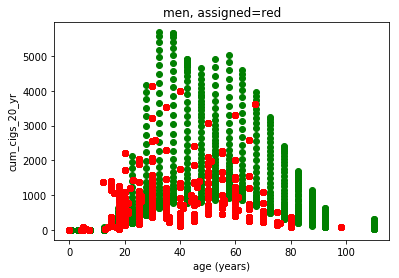

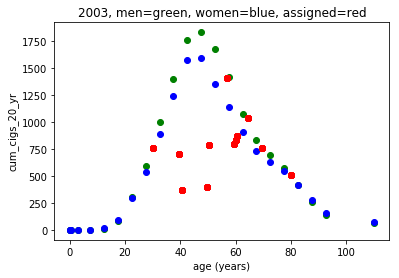

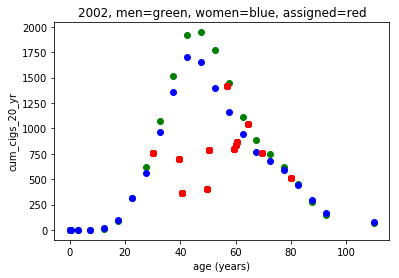

In [165]:
# Plot Covariate Value by Age by Sex

#fig, ax = plt.subplots()

cov_f = ccov_ranges_df[ccov_ranges_df["x_sex"] == -0.5]
cov_m = ccov_ranges_df[ccov_ranges_df["x_sex"] == 0.5]

#meas = measurements.iloc[0]["age_lower"]
meas = meas_5_both["age_lower"]
meas_5_both["avg_age"] = meas_5_both[["age_lower", "age_upper"]].mean(axis=1)
cc = meas_5_both["covariate_col"]

print(cov_f.shape)
print(cov_m.shape)

f_age = cov_f[["age_lower", "age_upper"]].mean(axis=1)
f_covariate = cov_f["mean_value"]

m_age = cov_m[["age_lower", "age_upper"]].mean(axis=1)
m_covariate = cov_m["mean_value"]

plt.figure(1)

plt.plot(f_age, f_covariate, 'bo')
plt.plot(meas, cc, "ro")


plt.xlabel("age (years)")
plt.ylabel(covariate_name)
plt.title(f"women, assigned=red")

#plt.set(xlabel='age (years)', ylabel=covariate_name,
#       title=f"{covariate_name} by age for women")

plt.figure(2)

plt.plot(m_age, m_covariate, 'go')

# print(f"meas: {meas}")
# print(f"cc: {cc}")
plt.plot(meas, cc, "ro")

plt.xlabel("age (years)")
plt.ylabel(covariate_name)
plt.title(f"men, assigned=red")

#plt.set(xlabel='age (years)', ylabel=covariate_name,
#       title=f"{covariate_name} by age for men")

meas_ss = meas_5_both[(meas_5_both["covariate_col"] < 500) & (meas_5_both["avg_age"] == 40.5)]
meas_ss_405 = meas_5_both[meas_5_both["avg_age"] == 40.5]

print(f"meas_ss_405: {meas_ss_405.shape}")
print(meas_ss.shape)
print(meas_ss["time_lower"])
print(meas_ss["time_upper"])

plt.figure(3)


cov_m_2003 = cov_m[(cov_m["time_lower"] == 2003) & (cov_m["time_upper"] == 2004)]
print(f"cov_m_2003: {cov_m_2003.shape}")

cov_m_2002 = cov_m[(cov_m["time_lower"] == 2002) & (cov_m["time_upper"] == 2003)]
print(f"cov_m_2002: {cov_m_2002.shape}")


cov_f_2003 = cov_f[(cov_f["time_lower"] == 2003) & (cov_f["time_upper"] == 2004)]
print(f"cov_f_2003: {cov_f_2003.shape}")

cov_f_2002 = cov_f[(cov_f["time_lower"] == 2002) & (cov_f["time_upper"] == 2003)]
print(f"cov_f_2002: {cov_f_2002.shape}")


m_age_2003 = cov_m_2003[["age_lower", "age_upper"]].mean(axis=1)
m_covariate_2003 = cov_m_2003["mean_value"]

m_age_2002 = cov_m_2002[["age_lower", "age_upper"]].mean(axis=1)
m_covariate_2002 = cov_m_2002["mean_value"]


f_age_2003 = cov_f_2003[["age_lower", "age_upper"]].mean(axis=1)
f_covariate_2003 = cov_f_2003["mean_value"]

f_age_2002 = cov_f_2002[["age_lower", "age_upper"]].mean(axis=1)
f_covariate_2002 = cov_f_2002["mean_value"]


plt.plot(m_age_2003, m_covariate_2003, "go")
plt.plot(f_age_2003, f_covariate_2003, "bo")

meas_2003 = meas_5_both[(meas_5_both["time_lower"]==2003) & (meas_5_both["time_upper"]==2003)]
print(f"meas_2003 shape: {meas_2003.shape}")
meas_2003_405 = meas_2003[meas_2003["avg_age"]==40.5]
print(f"meas_2003 40.5: \n{meas_2003_405['covariate_col']}")

plt.plot(meas_2003["avg_age"], meas_2003["covariate_col"], "ro")

plt.xlabel("age (years)")
plt.ylabel(covariate_name)
plt.title(f"2003, men=green, women=blue, assigned=red")
      
      
plt.figure(4)

plt.plot(m_age_2002, m_covariate_2002, "go")
plt.plot(f_age_2002, f_covariate_2002, "bo")

plt.plot(meas_2003["avg_age"], meas_2003["covariate_col"], "ro")

plt.xlabel("age (years)")
plt.ylabel(covariate_name)
plt.title(f"2002, men=green, women=blue, assigned=red")
      

plt.show()

